# Test Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('../../../data/amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      147718        546145  546146  B001AZ2UYI   AR4KQLKL8VJO4   
1      223621        478031  478032  B000WZZVI4  A2TIETTFZ3YYAU   
2      447075        348609  348610  B000E46GFA  A1GGO0VNCBFA0D   
3        9239        319904  319905  B0018QIPS4   A61OLW5P65ZK5   
4      424940        494951  494952  B00271OPVU  A37DKONQP3RMJO   

                       ProfileName  HelpfulnessNumerator  \
0                       W. Maxwell                    14   
1  Donna Toy "Foot comfort expert"                    10   
2                Karen M. Szymarek                     2   
3                         Khaleesi                     0   
4                    mytripletboys                     0   

   HelpfulnessDenominator  Score        Time  \
0                      15      5  1261785600   
1                      10      5  1201478400   
2                       2      5  1279929600   
3                       1      1  1338336000

### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [4]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text) #!!! not fitting and transforming -- only transforming
print(X_hv.shape)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 131072)


In [5]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [6]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [7]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        924
1      5        110
2      5        892
3      1        395
4      5        125
5      4        833
6      5        891
7      5        110
8      4        720
9      3        190
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [8]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131074)


### Create `X`, scaled matrix of features

In [9]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)
# check to make sure has same num columns as training

(91000, 131074)


In [5]:
from featuresPreparation import AmazonReviewFeaturePrep
featurePreparer = AmazonReviewFeaturePrep(amazon)

In [6]:
featurePreparer.rawData.shape

(91000, 14)

In [7]:
featurePreparer.prepare_all_features_test()

starting to prepare features


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


finished applying hash vectorizor
finished applying tfidf
starting quant features
starting product aggregates
finished product aggregates
finished quant features
scale applied
finished preparing test features


In [8]:
X = featurePreparer.X
X.shape

(91000, 131077)

### create `y`, vector of Labels

In [9]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [10]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle !!! important to use fit from training

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6708, 'FN': 4664, 'desc': 'svm', 'Recall': 0.30471079308288612, 'Precision': 0.28057652711050102, 'TN': 79051, 'Neg': 84292, 'Accuracy': 0.89115384615384619, 'FP': 5241, 'TP': 2044}


Previous results: {'FN': 4894, 'TN': 78482, 'desc': 'svm', 'Neg': 84292, 'Accuracy': 0.88237362637362637, 'FP': 5810, 'Pos': 6708, 'Precision': 0.23793284365162645, 'TP': 1814, 'Recall': 0.27042337507453784}


In [11]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6708, 'FN': 4200, 'desc': 'lgs', 'Recall': 0.37388193202146691, 'Precision': 0.24304680686112995, 'TN': 76481, 'Neg': 84292, 'Accuracy': 0.86801098901098905, 'FP': 7811, 'TP': 2508}


Previous Results: {'FN': 4823, 'TN': 78496, 'desc': 'lgs', 'Neg': 84292, 'Accuracy': 0.88330769230769235, 'FP': 5796, 'Pos': 6708, 'Precision': 0.2454107538080979, 'TP': 1885, 'Recall': 0.2810077519379845}

In [12]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6708, 'FN': 4088, 'desc': 'nbs', 'Recall': 0.39057841383422781, 'Precision': 0.17864448384017456, 'TN': 72246, 'Neg': 84292, 'Accuracy': 0.82270329670329667, 'FP': 12046, 'TP': 2620}


Previous Results: {'FN': 4083, 'TN': 71892, 'desc': 'nbs', 'Neg': 84292, 'Accuracy': 0.8188681318681319, 'FP': 12400, 'Pos': 6708, 'Precision': 0.17470881863560733, 'TP': 2625, 'Recall': 0.39132379248658317}

In [14]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6708, 'FN': 5757, 'desc': 'rdg', 'Recall': 0.14177101967799643, 'Precision': 0.43404837973528071, 'TN': 83052, 'Neg': 84292, 'Accuracy': 0.92310989010989009, 'FP': 1240, 'TP': 951}


Previous Results: {'FN': 5744, 'TN': 82883, 'desc': 'rdg', 'Neg': 84292, 'Accuracy': 0.92139560439560442, 'FP': 1409, 'Pos': 6708, 'Precision': 0.4062368310155921, 'TP': 964, 'Recall': 0.14370900417412044}


In [15]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6708, 'FN': 4665, 'desc': 'prc', 'Recall': 0.30456171735241505, 'Precision': 0.28629484304932734, 'TN': 79199, 'Neg': 84292, 'Accuracy': 0.89276923076923076, 'FP': 5093, 'TP': 2043}


Previous Results: {'FN': 5093, 'TN': 79157, 'desc': 'prc', 'Neg': 84292, 'Accuracy': 0.88760439560439564, 'FP': 5135, 'Pos': 6708, 'Precision': 0.23925925925925925, 'TP': 1615, 'Recall': 0.2407573047107931}

### ROC plot to compare performance of various models and fits

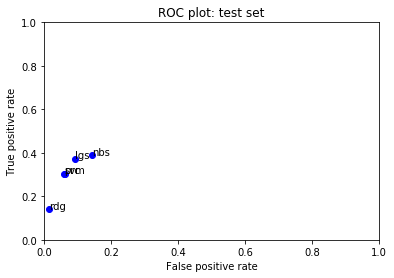

In [16]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()